# クラスタリング(2) : k-means法

代表的なクラスタリングアルゴリズムである k-means法について学ぼう．

[前回](https://bit.ly/2SiYtqt)は，Iris（あやめ）のデータベースから4次元の特徴量を持つデータに対してクラスタリングを行ったが，ここでは k-means法の挙動がわかりやすいように，2次元の特徴量を持つデータを人工的に作って作業を行おう．

このような目的に適したデータを生成するために便利なライブラリも sklearn に用意されている．

In [ ]:
from sklearn.datasets import make_blobs
X, y = make_blobs(n_samples = 150,
                  n_features = 2,  # 特徴量の個数．ここは固定．
                  centers = 3,
                  cluster_std = 0.8,
                  shuffle = True,
                  random_state = 0)

`make_blobs` には様々なオプション引数があるので，あとで色々と変化させながら試してみよう．ただし，以下は可視化に適した2次元のデータを対象とするので，`n_features = 2` は固定しておこう．それ以外は自由に変えてみましょう．

クラスタリングは「**教師なし学習**」のアルゴリズムであるため，クラスラベル y は使わない．（ただし，以下の例で見るように，sklearn の学習アルゴリズムにおいては，教師あり学習のアルゴリズムのインターフェースと揃えるために (X, y) を引数に指定することが多い）

### 練習課題




*  上の実験において，データの発生のさせ方（`make_blob`) を変化させたり，`KMeans`のオプション引数を変化させたりして，挙動を確かめよう．
  * n_clusters を変化させてみよう．
  * verbose = 1 を指定すると，アルゴリズムの実行過程を少し詳しく表示してくれる．

*  【中級者向き】2次元のデータに対して，k-means法を実装してみよう．k-近傍法のプログラムが参考になるかもしれない．
    * 参考情報：「実践 機械学習1：k近傍法」[k_nearest_nei001](https://bit.ly/2BmAwJw) と [説明動画](https://drive.google.com/open?id=1-_9aHvJR-bxtRwpacgc5jCdXHXvJbRg-&authuser=1)，[解答例](https://bit.ly/3dVqNYr)

このとき，sklearn.KMeans のインターフェースに合わせて実装しておけば，後々の処理に便利である．次のテンプレートが役に立つかも知れません．



###k-means cluster の実装


$k$ means clustering の実装の説明

---





1.   各クラスターの `self.labels_`が変化しなくなるまで、もしくは `counter` が `self.max_iter_`に達するまで、クラスターを更新し続ける. (Line 30 以降の while文を参照) 
2.   クラスターを更新するという意味は、1) 初めに適当に、Xを適当に`self.n_cluster`分に振り分ける. 2) 振り分けたクラスターの重心を求める. 3) どのクラスターの重心に一番近いのかを基に、クラスターのラベルを貼り直す. という意味である. 
3. 初めに、元のデータ (X) を、`self.n_cluster`分に分割するのは、line 22, 23 を参照されたい. 初めに、`list (range(0, self.n_cluster))`の反復列で構成される列 cycle を生成して、これを `np.random.permutation`を用いてランダムに並び替える. この並び替えられた列を、初期のクラスターラベルとしている. 
---
**10/16の授業での更新!!!**
1. 空のクラスターが出た場合、クラスター重心を前回では、適当な点をXから選んでいたが、今回は、前のクラスター重心により遠いXの点を新しい重心に設定している. 例えば、iter = 1 では全てのクラスターに空集合はなかったのに対して、iter = 2 では、クラスター1に空集合が出たとする. この時、iter = 1　のクラスター1の重心に最も遠い、Xの点を iter = 2 での新しいクラスター1の重心に添えるということである. なお、初期のクラスター重心では、空集合が出ないことを前提としている. 

2. また、k-meansクラスタリングの挙動はそのアルゴリズムの特性上、初期ラベル（乱数）に大きく依存するため、内部的にこの乱数を特定回生成して、一番小さい inertia を得た場合の初期ラベルを基にクラスタリングを行う. 

3. 前回のレポート提出時に見逃していたことだが、`KMeans2D`クラス中のメソッドである、_predict が2次元にしか対応していなかった. これを、任意の次元のベクトルに対する二乗距離を求められるようにした. 


In [ ]:
import numpy as np
from statistics import mean
from sklearn.base import BaseEstimator, ClusterMixin
import sys, math, copy 

class KMeans2D(BaseEstimator, ClusterMixin):
    """
    2次元のデータに特化して，sklearn のインターフェースに沿いながらk-means法を実装するためのテンプレート．
    """
    
    def __init__(self, n_clusters=3, n_init=1, max_iter = 300):
        "必要な初期化をここで行う．オプション引数も，必要に応じて追加していくとよいでしょう．"
        self.n_clusters = n_clusters
        self.n_init = n_init 
        self.max_iter = max_iter

        
    def fit(self, X, y=None):
        """クラスタリングの本体を記述する部分．なお，y は無視する．
        この fit さえ自分で記述すれば，ClusterMixin機能により，fit_predict(X) も自動的に動作するようになります．"""  

        #変数設定
        cycle = np.tile(list(range(self.n_clusters)), int (X.shape[0]/self.n_clusters)) 
        inertia_ = 100000 #これぐらい大きい値で初期化しておく. 
        # list(range(0, self.n_clusters))を X.shape[0]/self.n_clusters分反復する. 
        # しかし、X.shape[0]が、いつもself.n_clustersで割れるか分からないので、割れなかった場合は、適当に要素を追加する. 
        while len(cycle) < X.shape[0]: #cycleの要素数が、X.shape[0]に達するまで、要素を適当に追加している. 
            cycle = np.append(cycle, np.random.randint(0, self.n_clusters))

        #ここから、クラスタリングのアルゴリズム
        for N in range(self.n_init): #n_initで指定した回数だけ、初期クラスターを変えてみて、一番小さい、inertiaを返すラベルを最終的な labels_に指定する. 
            labels_ = np.random.permutation(cycle) # cycleをランダムにシャッフルして、3つのクラスターラベルを生成. このシャッフルを指定の回数繰り返して、一番良いineriaが出る初期ラベルを選択する. 
            label_prev = np.zeros(X.shape[0], dtype=np.int)
            centroid = [0]*self.n_clusters
            for n in range(self.n_clusters):
                XX = X[labels_ == n]  #各クラスターの座標 
                centroid[n] = [mean(XX[:, k]) for k in range(X.shape[1])] #クラスターの重心座標
            iter_ = 0
            counter = 0 
            while (not (labels_ == label_prev).all() and counter < self.max_iter): #クラスターが変化しなくなった場合、もしくは、指定の回数(max_iter)に達した場合、操作を終了する. 
                centroid_prev = copy.deepcopy(centroid)
                centroid = [False]*self.n_clusters
                for n in range(self.n_clusters): 
                    if not (labels_ == n).any() : #特定のクラスターが空集合の場合、その重心と最も遠い距離にあるデータの座標を新しい重心として設定する. 
                        dist = [self._distance(centroid_prev[n], X[i]) for i in range(X.shape[0])] 
                        centroid[n] = X[np.argmax(dist)] #距離が最大になるインデックスのデータに貼りかえる. 
                    # 3つのクラスターの重心を求める
                    if type (centroid[n]) == bool: #以下は、空集合でないクラスターの重心座標に対しての操作
                        XX = X[labels_ == n]  #各クラスターの座標 
                        centroid[n] = [mean(XX[:, k]) for k in range(X.shape[1])] #クラスターの重心座標
                label_prev = copy.deepcopy(labels_) # label_prev を更新
                for j in range(X.shape[0]): # ラベルの貼り直し
                    dist_list = [self._distance(X[j], centroid[k]) for k in range(self.n_clusters)]
                    labels_[j] = np.argmin(dist_list)
                counter += 1
            
            #inertia の計算
            norm_square = 0 
            for n in range(self.n_clusters):
                X_X = X[labels_==n]
                for i in range(X_X.shape[0]): 
                    norm_square = norm_square + (self._distance(X_X[i], centroid[n]))**2

            centroid = np.array(centroid)
            iter_ = counter
            if norm_square < inertia_: #inertiaが最小の時の、labels_, inertia_, cluster_centers_, iter_を返す. 
                inertia_ = copy.deepcopy(norm_square)
                self.labels_ = labels_
                self.inertia_ = inertia_
                self.cluster_centers_ = centroid
                self.iter_ = iter_

        return self

    # k-近傍法のアルゴリズムとも類似点があるので，そのとき作ったこの関数も役に立つかも知れません．
    def _distance(self, p, q):
        """点 p と q の間のユークリッド距離を計算して返す．
        n次元に対応する."""
        dist_square = 0 
        for pp, qq in zip(p, q):
            dist_square += (pp - qq)**2
        return math.sqrt(dist_square)

In [ ]:
km = KMeans2D(n_clusters=3, n_init=3)
km.fit(X)

KMeans2D(max_iter=300, n_clusters=3, n_init=3)

In [ ]:
km.fit_predict(X)

array([2, 1, 1, 1, 2, 1, 1, 2, 0, 1, 2, 2, 0, 1, 1, 0, 0, 2, 0, 2, 1, 2,
       1, 1, 0, 2, 2, 1, 0, 2, 0, 0, 0, 0, 1, 2, 2, 2, 1, 1, 0, 0, 1, 2,
       2, 2, 0, 2, 0, 1, 2, 1, 1, 2, 2, 0, 1, 2, 0, 1, 0, 1, 0, 0, 1, 1,
       1, 2, 1, 1, 1, 2, 2, 1, 2, 1, 1, 0, 0, 1, 2, 2, 1, 1, 2, 2, 2, 0,
       0, 2, 2, 1, 2, 1, 2, 1, 0, 0, 2, 2, 2, 2, 0, 2, 2, 1, 0, 1, 1, 1,
       0, 1, 2, 0, 1, 0, 1, 1, 0, 0, 1, 2, 1, 1, 2, 2, 0, 2, 0, 0, 0, 0,
       2, 0, 0, 0, 1, 0, 2, 0, 1, 1, 2, 2, 0, 0, 0, 0, 2, 2])

各クラスターのラベル`y_km`及び、根拠となる重心座標`cluster_centers`、各クラスター重心からの距離の二乗である`inertia`を表示してみる. 

In [ ]:
print('cluster label :', km.labels_)
print()
print('cluster_center :', km.cluster_centers_)
print()
print('inertia :', km.inertia_)

cluster label : [2 1 1 1 2 1 1 2 0 1 2 2 0 1 1 0 0 2 0 2 1 2 1 1 0 2 2 1 0 2 0 0 0 0 1 2 2
 2 1 1 0 0 1 2 2 2 0 2 0 1 2 1 1 2 2 0 1 2 0 1 0 1 0 0 1 1 1 2 1 1 1 2 2 1
 2 1 1 0 0 1 2 2 1 1 2 2 2 0 0 2 2 1 2 1 2 1 0 0 2 2 2 2 0 2 2 1 0 1 1 1 0
 1 2 0 1 0 1 1 0 0 1 2 1 1 2 2 0 2 0 0 0 0 2 0 0 0 1 0 2 0 1 1 2 2 0 0 0 0
 2 2]

cluster_center : [[-1.75331622  2.9376426 ]
 [ 0.84069413  4.35679782]
 [ 2.05130138  1.06134965]]

inertia : 182.24830062439057


最終的なクラスター分析の回数 `actual_iter`を表示してみる. 

In [ ]:
print('final iteration is :', km.iter_)

final iteration is : 6


クラスター分析の結果を元のデータの正解ラベルとともに描写してみる. その時、各クラスターの中心をXで表す. 

In [ ]:
import matplotlib.pyplot as plt 

def cluster_visualize(n , X): 
    # n=3でうまくいくようになっている. 
    color_list = ['lightgreen', 'orange', 'lightblue']
    marker_list = ['o', '^', 'v']
    y_km = km.labels_
    cluster_centers = km.cluster_centers_

    plt.figure(figsize=(15, 5))

    #クラスターの描写
    plt.subplot(121)
    for i in range(n):
        plt.scatter(X[y_km==i, 0], X[y_km==i, 1], s=30, c=color_list[i], marker=marker_list[i], label=f'cluster{i+1}')

    plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], c='red', marker='x', s=100)
    plt.title(f'K-Means Clustering Label : iteration = {km.iter_}')
    plt.legend()
    plt.grid()

    #元のデータのラベルを描写
    plt.subplot(122)
    for i in range(n):
        plt.scatter(X[y==i, 0], X[y==i, 1], s=30, c=color_list[i], marker=marker_list[i], label=f'label{i}')
    plt.title('Actual Label')
    plt.legend()
    plt.grid()
    plt.show()

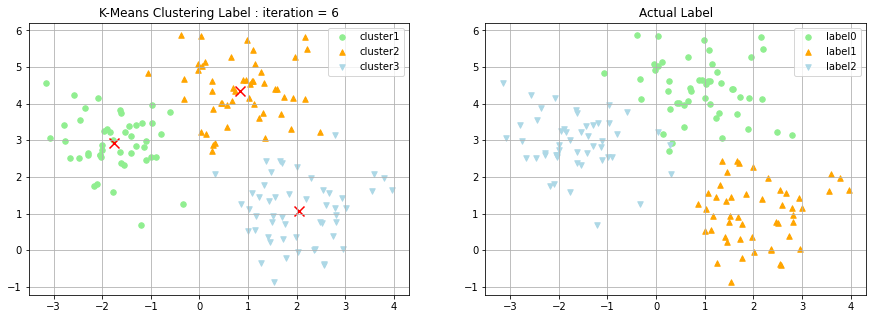

In [ ]:
cluster_visualize(n=3, X=X)

クラスターの数を、変化させてみる. 試しに、n = 5に指定してみる. 

In [ ]:
km2 = KMeans2D(n_clusters=5, n_init=5).fit(X)

In [ ]:
y_km2 = km2.labels_
cluster_centers2 = km2.cluster_centers_

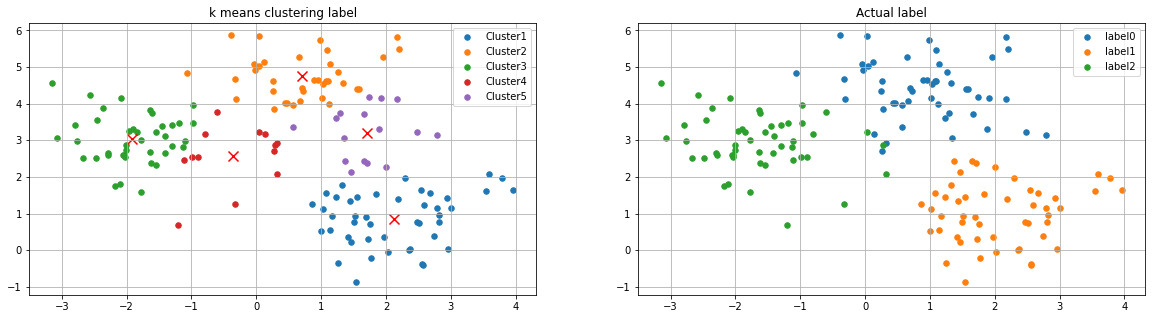

In [ ]:
n = 5 

plt.figure(figsize=(20, 5))
plt.subplot(121)
for i in range(5): 
    plt.scatter(X[y_km2 == i, 0], X[y_km2==i, 1], s=30, label=f'Cluster{i+1}')
plt.scatter(cluster_centers2[:, 0], cluster_centers2[:, 1], marker='x', c='red', s=100)
plt.title('k means clustering label')
plt.legend()
plt.grid()

n_feature = 3
plt.subplot(122)
for i in range(n_feature): 
    plt.scatter(X[y==i, 0], X[y==i, 1], s=30, label=f'label{i}')
plt.title('Actual label')
plt.legend()
plt.grid()
plt.show()

###Irisデータのクラスタリング

【練習問題の続き】
*  【中～上級者向き】numpy の機能をうまく利用して，k-means 法を実装してみよう．そうすれば2次元以上のデータに対する拡張が容易に，かつ効率よく行えるようになるだろう．


irisデータ(4次元の特徴量を持つ)で自作の k-means clustering を試してみる. 

In [ ]:
from sklearn import datasets
iris = datasets.load_iris()
X_iris = iris.data
y_iris = iris.target

In [ ]:
km = KMeans2D(n_clusters=3, n_init=5)
km.fit(X_iris)

KMeans2D(max_iter=300, n_clusters=3, n_init=5)

In [ ]:
print('iris_cluster label', km.labels_)
print('iris_cluster center', km.cluster_centers_)
print('iris_cluster iteration', km.iter_)

iris_cluster label [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 1 1 0 1 1 1 1
 1 1 0 0 1 1 1 1 0 1 0 1 0 1 1 0 0 1 1 1 1 1 0 1 1 1 1 0 1 1 1 0 1 1 1 0 1
 1 0]
iris_cluster center [[5.9016129  2.7483871  4.39354839 1.43387097]
 [6.85       3.07368421 5.74210526 2.07105263]
 [5.006      3.428      1.462      0.246     ]]
iris_cluster iteration 8


In [ ]:
ykm_iris = km.labels_
iris_cluster_center = km.cluster_centers_

Iris データの特徴量を任意に2つ選んで、描写してみる. 左が、クラスタリングの結果で、右が実データの正解ラベルです. 

**10/16更新!** 
今回の授業で学んだ、`itertools_combinations`を用いている. 今回は、4つの特徴量を2つ任意に選ぶのに、`combinations(range(4), 2)`という風に用いている. 

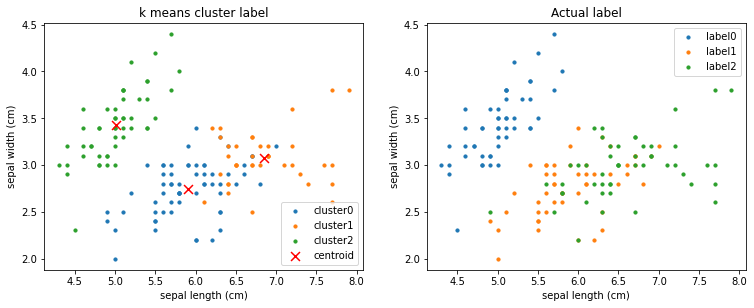

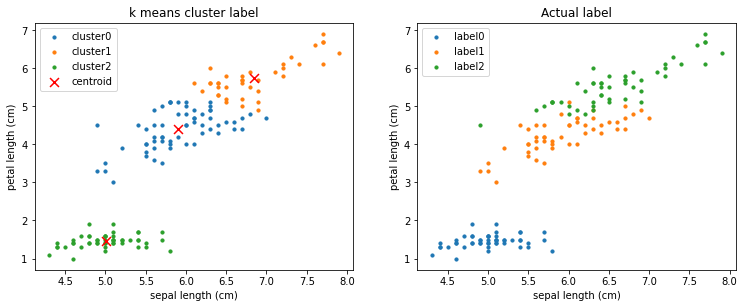

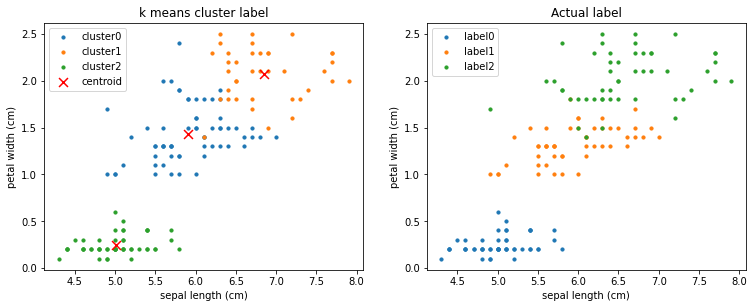

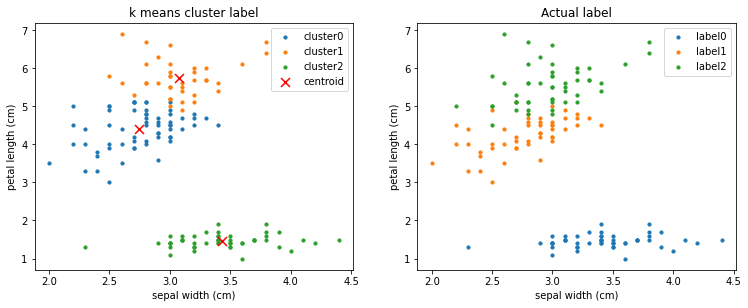

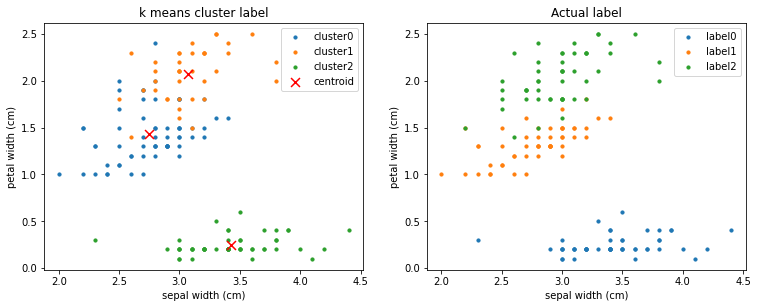

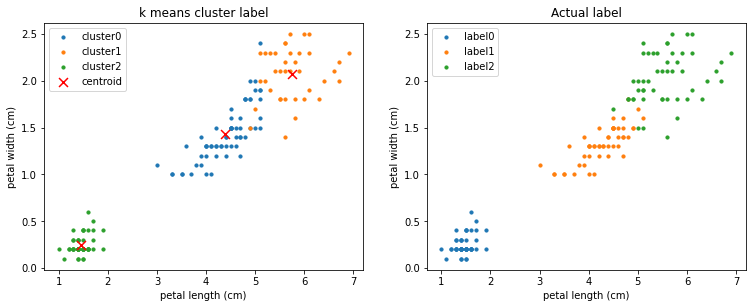

In [ ]:
from itertools import combinations
comb = list (combinations(range(X_iris.shape[1]), 2))

for i in range(len(comb)): 
    a = comb[i][0] #1つ目の特徴量
    b = comb[i][1] #2つ目の特徴量
    plt.figure(figsize=(40, 10)) 
    plt.subplot(2, 6, 2*(i+1)-1)
    for k in range(len(iris.target_names)): 
        plt.scatter(X_iris[ykm_iris == k, a], X_iris[ykm_iris == k, b], label = f'cluster{k}', s = 10)
        plt.xlabel(iris.feature_names[a])
        plt.ylabel(iris.feature_names[b])
        plt.title('k means cluster label')
        plt.legend()
    plt.scatter(iris_cluster_center[:, a], iris_cluster_center[:, b], label = 'centroid', c = 'red', marker='x', s=80)
    plt.xlabel(iris.feature_names[a])
    plt.ylabel(iris.feature_names[b])
    plt.title('k means cluster label')
    plt.legend()
    # plt.grid()

    plt.subplot(2, 6, 2*(i+1))
    for k in range(len(iris.target_names)): 
        plt.scatter(X_iris[y_iris == k, a], X_iris[y_iris == k, b], label = f'label{k}', s = 10)
        plt.legend()
    plt.xlabel(iris.feature_names[a])
    plt.ylabel(iris.feature_names[b])
    plt.title('Actual label')
    # plt.grid()

大体いい感じであったっていることが分かる. しかし、両方のラベルにともに近いデータのクラスタリングは多少の間違いが見られる. 

###k-means++ を用いて、クラスタリングの初期ラベル（ランダムに設定されたクラスター中心に大きく依存するという k-means clustering の問題点）を改善する. (10/16以降更新) 

k-means++のアルゴリズム:

1. データポイント(ここでは、X）からランダムに1つ点を選択し、これを1つ目のクラスター中心とする. 

2. 各データポイント $x_i$ と最近傍中心との距離の二乗 $d(x_i)^2$ を計算する. 

3. 2で求めた $d(x_i)$ が一番大きくなる点を2つ目のクラスター中心とする.　最近傍中心とは、データ $x_i$に最も近いクラスター中心のことである. 初めは、1つ目のクラスター中心のことを指す. 

4. クラスター中心の数が、`self.n_clusters`に達するまで、2と3を繰り返す. 

5. 初回のクラスター中心が定まったら、それに応じて各データに初回のクラスターラベルを割り振る. この操作以降は、前回実装したk-means法の操作と全く同じ. 

なお、このアルゴリズム作成の際には、https://www.geeksforgeeks.org/ml-k-means-algorithm/ を参考にした. また、$d(x_i)^2$ではなく、$\frac{d(x_i)^2} {\sum_{i=1}^{N} d(x_i)^2}$の確立分布を基に、クラスター中心を決める、としているサイト（https://qiita.com/NoriakiOshita/items/cbd46d907d196efe64a3 ）もあったが、本質的には同じことなので、今回は2の方針で初期クラスター中心を決定する. 

In [ ]:
import numpy as np
from statistics import mean
from sklearn.base import BaseEstimator, ClusterMixin
import sys, math, copy 

class KMeans_plus_plus(BaseEstimator, ClusterMixin):
    """
    2次元のデータに特化して，sklearn のインターフェースに沿いながらk-means法を実装するためのテンプレート．
    """
    
    def __init__(self, n_clusters=3, n_init=1, max_iter = 300):
        "必要な初期化をここで行う．オプション引数も，必要に応じて追加していくとよいでしょう．"
        self.n_clusters = n_clusters
        self.n_init = n_init 
        self.max_iter = max_iter

        
    def fit(self, X, y=None):
        """クラスタリングの本体を記述する部分．なお，y は無視する．
        この fit さえ自分で記述すれば，ClusterMixin機能により，fit_predict(X) も自動的に動作するようになります．"""  

        #変数設定
        inertia_ = 100000 #これぐらい大きい値で初期化しておく. 

        #ここから、クラスタリングのアルゴリズム
        for N in range(self.n_init): #n_initで指定した回数だけ、初期クラスターを変えてみて、一番小さい、inertiaを返すラベルを最終的な labels_に指定する.
            ####これが、k-means++での変更点####
            first_centroid = X[np.random.randint(0, X.shape[0])] #1番の操作 ここだけ、乱数が絡む. 
            #2乗距離になっていたが、距離でも本質的に変わらない. 
            # print(first_centroid) #debag 
            first_centroid = np.vstack([first_centroid, X[np.argmax([self._distance(first_centroid, x) for x in X])]]) #2, 3番の操作
            # print(first_centroid) #debag
            while first_centroid.shape[0] < self.n_clusters : #4番の操作
                nearest_center = np.zeros(X.shape[0], dtype=np.int)
                for n in range(X.shape[0]):
                    #各データの際近傍中心の抽出
                    nearest_center[n] = np.argmin([self._distance(X[n], first_centroid[i]) for i in range(first_centroid.shape[0])]) 
                first_centroid = np.vstack([first_centroid, X[np.argmax([self._distance(first_centroid[nearest_center[i]], X[i]) for i in range(X.shape[0])])]])
            centroid = copy.deepcopy(first_centroid)
            # print(nearest_center) #debag
            # print(centroid) #debag

            labels_ = np.zeros(X.shape[0])
            for i in range(X.shape[0]): 
                labels_[i] = np.argmin([self._distance(X[i], x) for x in centroid])
            label_prev = np.zeros(X.shape[0], dtype=np.int)
            ########
            iter_ = 0
            counter = 0 
            while (not (labels_ == label_prev).all() and counter < self.max_iter): #クラスターが変化しなくなった場合、もしくは、指定の回数(max_iter)に達した場合、操作を終了する. 
                centroid_prev = copy.deepcopy(centroid)
                centroid = [False]*self.n_clusters
                for n in range(self.n_clusters): 
                    if not (labels_ == n).any() : #特定のクラスターが空集合の場合、その重心と最も遠い距離にあるデータの座標を新しい重心として設定する. 
                        dist = [self._distance(centroid_prev[n], X[i]) for i in range(X.shape[0])] 
                        centroid[n] = X[np.argmax(dist)] #距離が最大になるインデックスのデータに貼りかえる. 
                    # 3つのクラスターの重心を求める
                    if type (centroid[n]) == bool: #以下は、空集合でないクラスターの重心座標に対しての操作
                        XX = X[labels_ == n]  #各クラスターの座標 
                        centroid[n] = [mean(XX[:, k]) for k in range(X.shape[1])] #クラスターの重心座標
                label_prev = copy.deepcopy(labels_) # label_prev を更新
                for j in range(X.shape[0]): # ラベルの貼り直し
                    dist = [self._distance(X[j], centroid[k]) for k in range(self.n_clusters)]
                    labels_[j] = np.argmin(dist)
                counter += 1
            
            #inertia の計算
            norm_square = 0 
            for n in range(self.n_clusters):
                X_X = X[labels_==n]
                for i in range(X_X.shape[0]): 
                    norm_square = norm_square + (self._distance(X_X[i], centroid[n]))**2

            centroid = np.array(centroid)
            iter_ = counter
            if norm_square < inertia_: #inertiaが最小の時の、labels_, inertia_, cluster_centers_, iter_を返す. 
                inertia_ = copy.deepcopy(norm_square)
                self.labels_ = labels_
                self.inertia_ = inertia_
                self.cluster_centers_ = centroid
                self.iter_ = iter_

        return self

    # k-近傍法のアルゴリズムとも類似点があるので，そのとき作ったこの関数も役に立つかも知れません．
    def _distance(self, p, q):
        """点 p と q の間のユークリッド距離を計算して返す．
        n次元に対応する."""
        dist_square = 0 
        for pp, qq in zip(p, q):
            dist_square += (pp - qq)**2
        return math.sqrt(dist_square)

In [ ]:
km = KMeans_plus_plus(n_clusters=3, n_init=5)

In [ ]:
km.fit(X)

KMeans_plus_plus(max_iter=300, n_clusters=3, n_init=5)

各クラスターのラベル`y_km`及び、根拠となる重心座標`cluster_centers`、各クラスター重心からの距離の二乗である`inertia`を表示してみる. 

In [ ]:
print('cluster label :', km.labels_)
print()
print('cluster_center :', km.cluster_centers_)
print()
print('inertia :', km.inertia_)

cluster label : [1. 2. 2. 2. 1. 2. 2. 1. 0. 2. 1. 1. 0. 2. 2. 0. 0. 1. 0. 1. 2. 1. 2. 2.
 0. 1. 1. 2. 0. 1. 0. 0. 0. 0. 2. 1. 1. 1. 2. 2. 0. 0. 2. 1. 1. 1. 0. 1.
 0. 2. 1. 2. 2. 1. 1. 0. 2. 1. 0. 2. 0. 2. 0. 0. 2. 2. 2. 1. 0. 2. 2. 1.
 1. 2. 1. 2. 2. 0. 0. 2. 1. 1. 2. 2. 1. 1. 1. 0. 0. 1. 1. 2. 1. 2. 1. 2.
 0. 0. 1. 1. 1. 1. 0. 1. 1. 2. 0. 2. 2. 2. 0. 2. 1. 0. 2. 0. 2. 2. 0. 0.
 2. 1. 2. 2. 1. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 2. 0. 1. 0. 2. 2. 1. 1.
 0. 0. 0. 0. 1. 1.]

cluster_center : [[-1.73899967  2.97699759]
 [ 2.05130138  1.06134965]
 [ 0.87883045  4.34740013]]

inertia : 182.27095306454652


最終的なクラスター分析の回数 `actual_iter`を表示してみる. 

In [ ]:
print('final iteration is :', km.iter_)

final iteration is : 4


クラスター分析の結果を元のデータの正解ラベルとともに描写してみる. その時、各クラスターの中心をXで表す. 

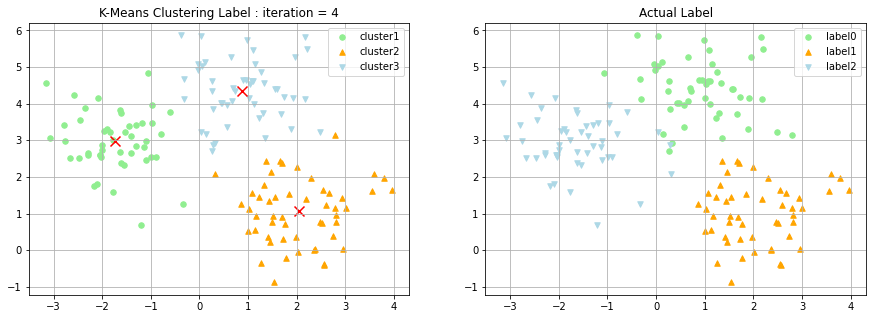

In [ ]:
cluster_visualize(n=3, X=X)

Irisデータをクラスター分析してみる. 

In [ ]:
km = KMeans_plus_plus(n_clusters=3, n_init=5)
km.fit(X_iris)

KMeans_plus_plus(max_iter=300, n_clusters=3, n_init=5)

In [ ]:
ykm_iris = km.labels_
iris_cluster_center = km.cluster_centers_

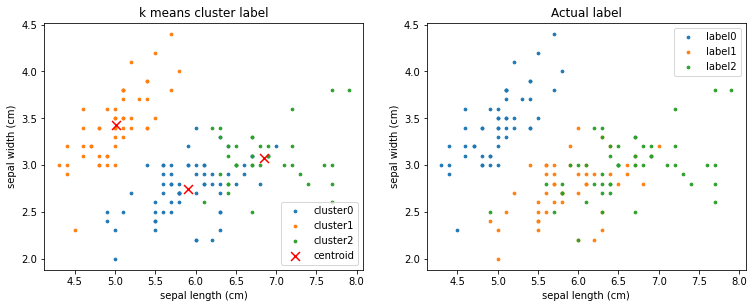

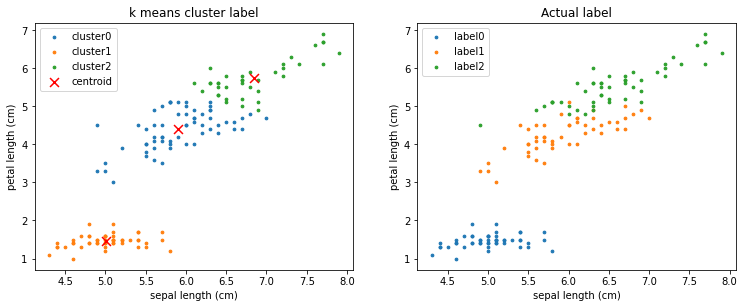

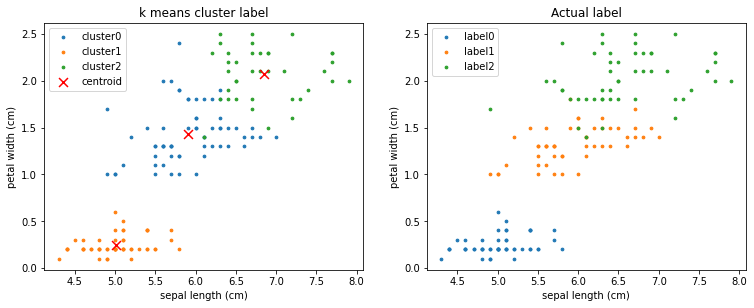

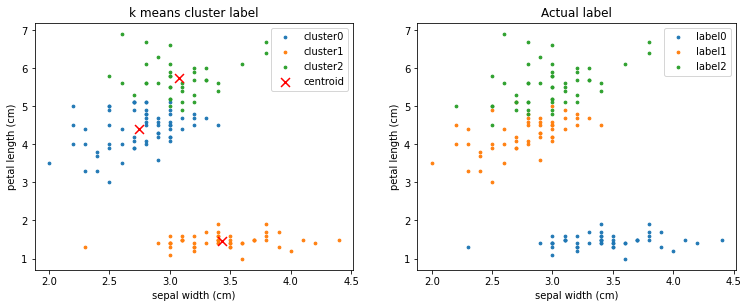

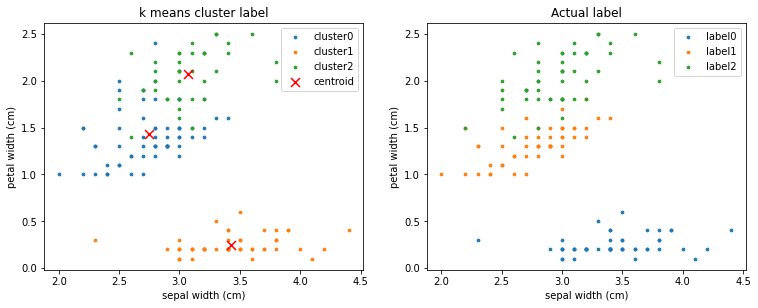

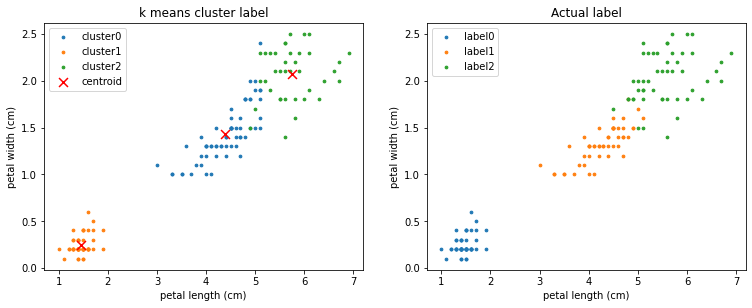

In [ ]:
from itertools import combinations
comb = list (combinations(range(X_iris.shape[1]), 2))

for i in range(len(comb)): 
    a = comb[i][0] #1つ目の特徴量
    b = comb[i][1] #2つ目の特徴量
    plt.figure(figsize=(40, 10)) 
    plt.subplot(2, 6, 2*(i+1)-1)
    for k in range(len(iris.target_names)): 
        plt.scatter(X_iris[ykm_iris == k, a], X_iris[ykm_iris == k, b], label = f'cluster{k}', s = 30, marker='.')
        plt.xlabel(iris.feature_names[a])
        plt.ylabel(iris.feature_names[b])
        plt.title('k means cluster label')
        plt.legend()
    plt.scatter(iris_cluster_center[:, a], iris_cluster_center[:, b], label = 'centroid', c = 'red', marker='x', s=80)
    plt.xlabel(iris.feature_names[a])
    plt.ylabel(iris.feature_names[b])
    plt.title('k means cluster label')
    plt.legend()
    # plt.grid()

    plt.subplot(2, 6, 2*(i+1))
    for k in range(len(iris.target_names)): 
        plt.scatter(X_iris[y_iris == k, a], X_iris[y_iris == k, b], label = f'label{k}', s = 30, marker='.')
        plt.legend()
    plt.xlabel(iris.feature_names[a])
    plt.ylabel(iris.feature_names[b])
    plt.title('Actual label')
    # plt.grid()

やはり、両方のクラスターに近いデータポイントは、正確にクラスタリングできていないようだ. しかし、正解ラベルと照らし合わせると、おおよそ正確にクラスタリングできており、k-meansより精度が上がっているように見える. sepal width VS petal length での描写を見比べると、k-means++の方が正確にクラスタリングができていることが分かる. 

### 適切なクラスターの選び方

上の irisデータをクラスター分析する場合に、クラスターの数 `n_clusters`はどれが一番妥当なのか、調べる. その際、どれが良いか、というのは `km.inertia_`の値を基に決める. 具体的には、**エルボー法 (*Elbow Method*)** というものを用いて、適切なクラスター数を求める. 


---

**エルボー法の説明** : 
x軸のクラスター数に応じて、クラスター内SSE(クラスターのinertia_)をy軸にプロットする. そして、inertia が "ヒジ"のように (だから、エルボー法) ガクんと曲がった点が最適なクラスター数を示す、というのがエルボー法の概要である. しかし、実社会で扱われるデータではこの特徴が顕著でないため、エルボー法では限界があるらしい. そこで、**シルエット分析 (Silhouette Analysis)**というものが導入されるらしい. 

参考資料: https://qiita.com/deaikei/items/11a10fde5bb47a2cf2c2

n = 1 : 681.3705999999996
n = 2 : 152.3479517603579
n = 3 : 78.851441426146
n = 4 : 57.35088021295475
n = 5 : 46.46117267267268
n = 6 : 39.06603535353536
n = 7 : 35.016121435427316
n = 8 : 30.426656417112312
n = 9 : 28.90233838383838
n = 10 : 26.797593653930623


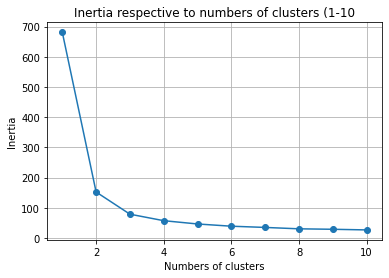

In [ ]:
distortion = []

n = 10 # Maximum numbers of clusters you want to generate 

for i in range(1, n+1):
    km = KMeans_plus_plus(n_clusters=i, n_init=5)
    km.fit(X_iris)
    print(f"n = {i} : {km.inertia_}")
    distortion.append(km.inertia_)

plt.plot(range(1, n+1), distortion, marker='o')
plt.xlabel("Numbers of clusters")
plt.ylabel("Inertia")
plt.title("Inertia respective to numbers of clusters (1-10")
plt.grid()
plt.show()

### シルエット分析 (Silhouette Analysis）の概要

以下、sklearnの[公式サイト](https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html#example-cluster-plot-kmeans-silhouette-analysis-py%5D)から、ソースコードを掲載する. 

通常、シルエット分析は各クラスターがどれくらい離れているかを知るために使われる. 特に、**シルエットプロット (Silhouette Plot)** というものが、あるクラスターに属するデータが最近傍のクラスターに属するデータとどれくらい近いかを示す. この値**シルエット係数 (Silhouette Coefficient)** は [-1, 1] の値の範囲を取り、値が1の場合はそのクラスターは他のクラスターと十分離れており、値が 0 の時は一部のクラスターが重なっており、負の値の場合は、いくつかのデータが間違ったクラスターに振り分けられていることを指す. このシルエットプロットは、次の3つの側面からクラスター数 `n_clusters`が妥当なのかを根拠づけてくれる. 

1. 任意のクラスターのシルエット係数が全体のシルエット係数の平均 (下の図での赤い点線）よりも大きいか

2. 各クラスターのシルエット係数のばらつきが小さいか

3. 各クラスターのシルエットプロットの厚さがなるべく均一になっているか

Automatically created module for IPython interactive environment
For n_clusters = 2 The average silhouette_score is : 0.7049787496083262
For n_clusters = 3 The average silhouette_score is : 0.5882004012129721
For n_clusters = 4 The average silhouette_score is : 0.6505186632729437
For n_clusters = 5 The average silhouette_score is : 0.5745566973301872
For n_clusters = 6 The average silhouette_score is : 0.43902711183132426


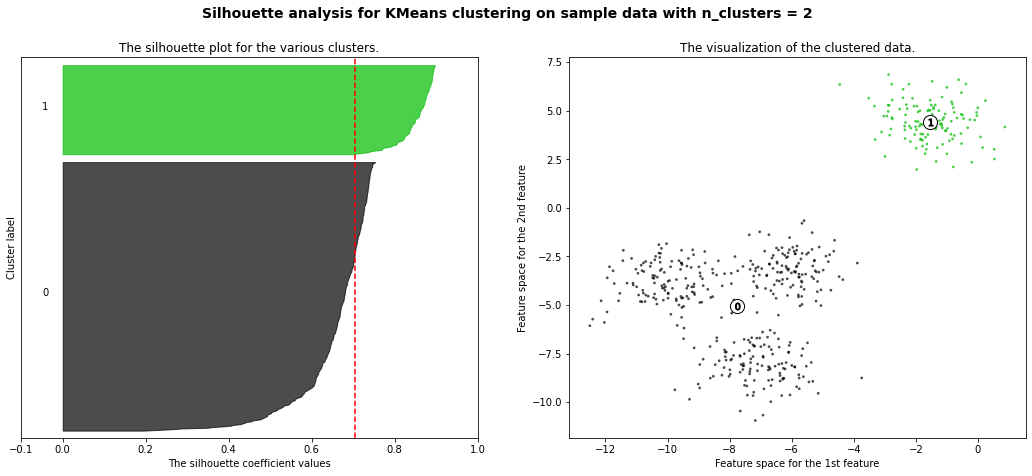

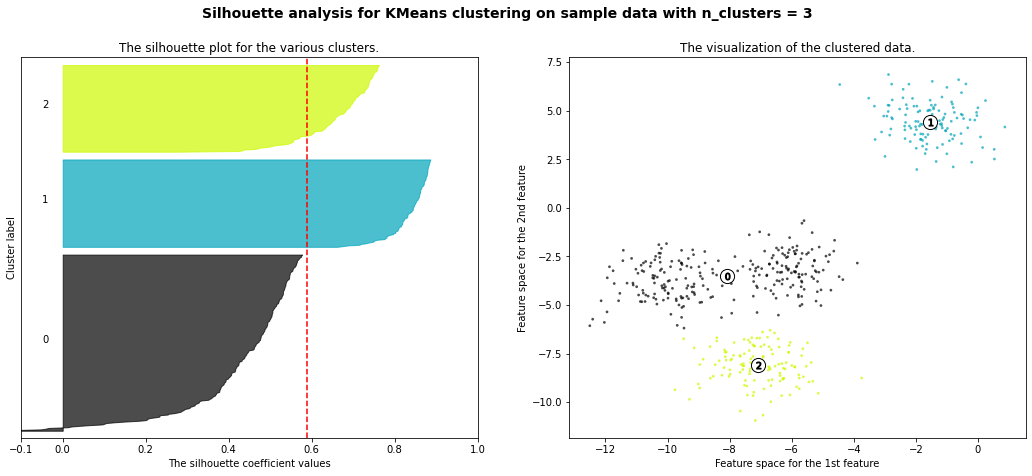

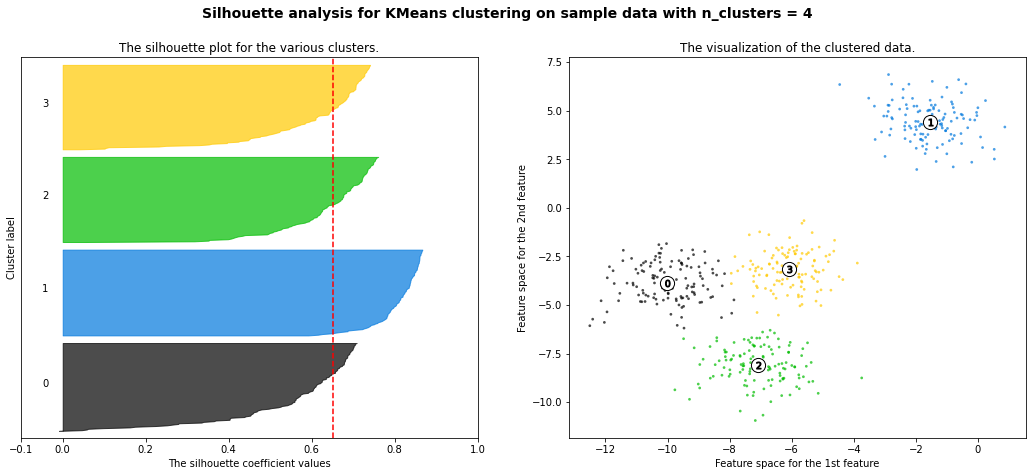

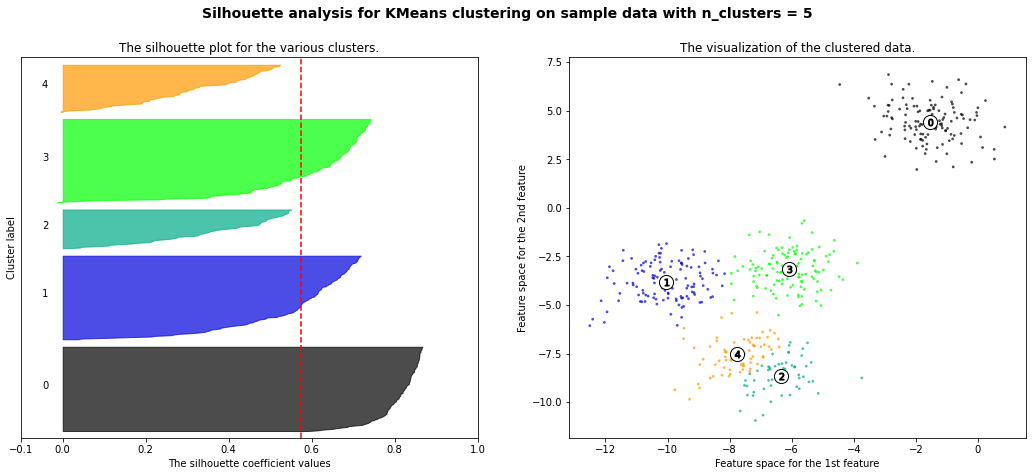

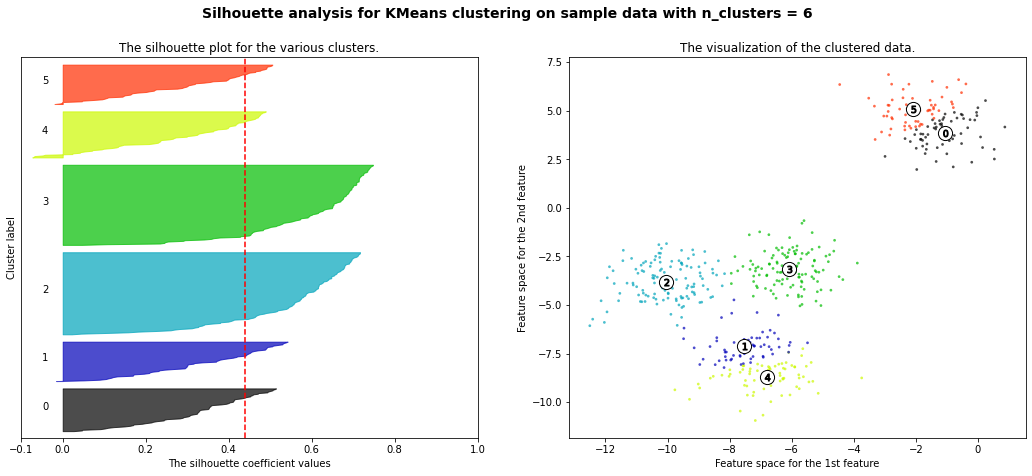

In [ ]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

print(__doc__)

# Generating the sample data from make_blobs
# This particular setting has one distinct cluster and 3 clusters placed close
# together.
X, y = make_blobs(n_samples=500,
                  n_features=2,
                  centers=4,
                  cluster_std=1,
                  center_box=(-10.0, 10.0),
                  shuffle=True,
                  random_state=1)  # For reproducibility

range_n_clusters = [2, 3, 4, 5, 6]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()


まず、1, 2番の基準から `n_clusters = 3, 5, 6`は適切でないことが分かる. それぞれ平均のシルエット係数よりも小さいクラスターがあり、シルエット係数の大きさの分散が大きいからだ. では、次に `n_clusters = 2, 4`を調べる. 3番の基準を考えると、シルエットプロットの厚さがほぼ均一なのは `n_clusters = 4` の時だと分かる. したがって、`n_clusters = 4`が適切なクラスター数であることが分かる. 

同じようにして、irisデータも分析してみる. すると同じような理由で、`n_clusters = 3` が一番妥当だということが分かる. 

Automatically created module for IPython interactive environment
For n_clusters = 2 The average silhouette_score is : 0.681046169211746
For n_clusters = 3 The average silhouette_score is : 0.5528190123564091
For n_clusters = 4 The average silhouette_score is : 0.4980505049972867
For n_clusters = 5 The average silhouette_score is : 0.4887488870931048
For n_clusters = 6 The average silhouette_score is : 0.3648340039670018


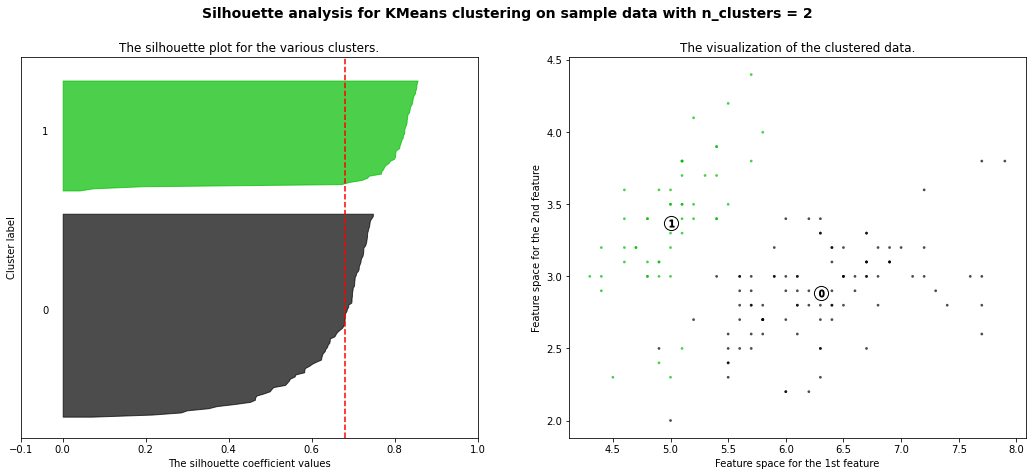

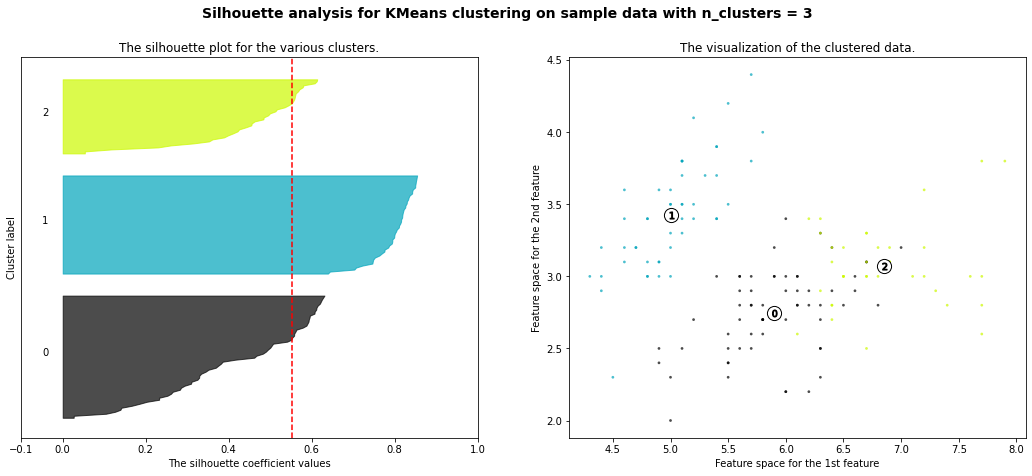

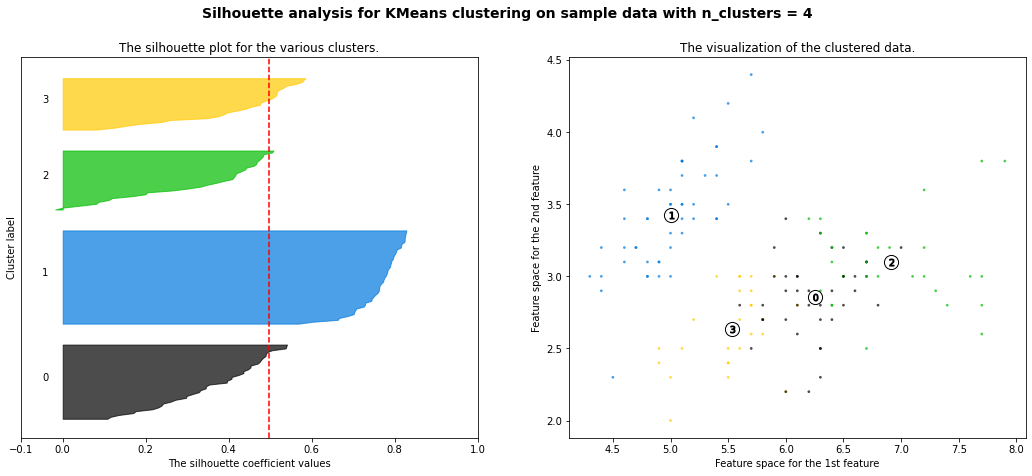

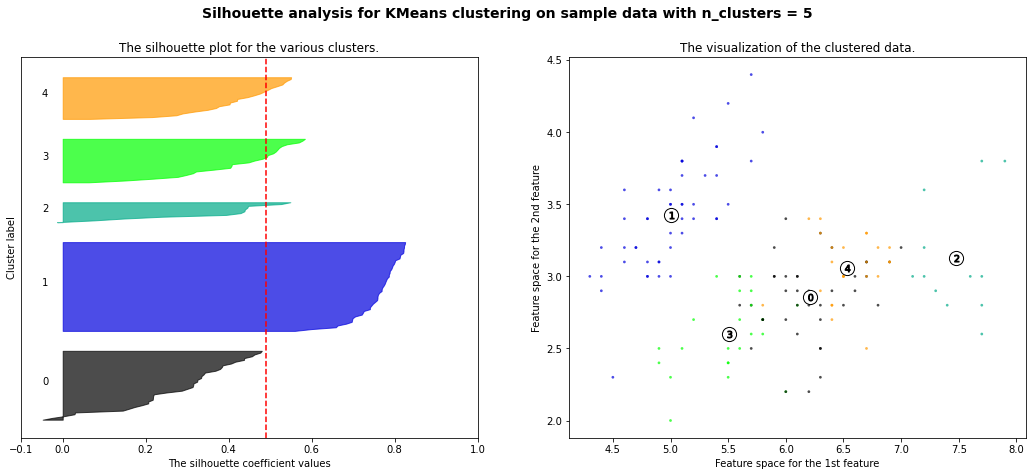

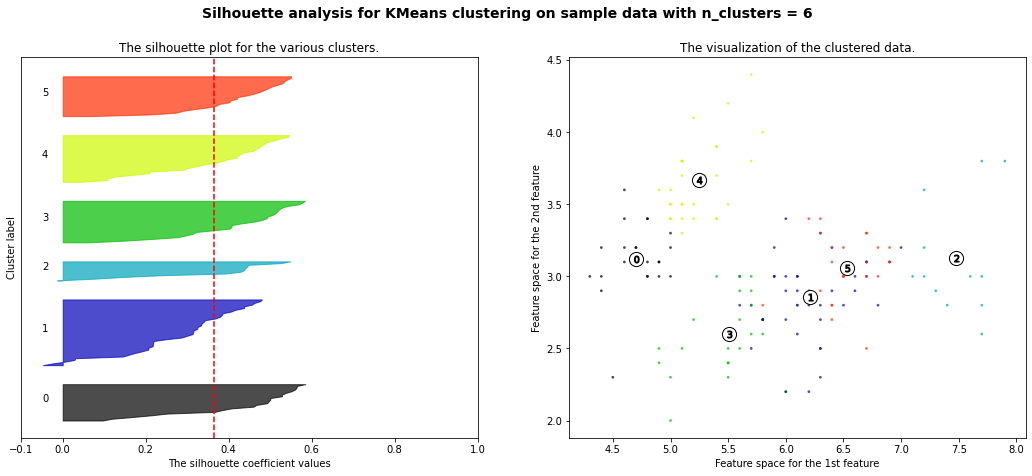

In [ ]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

print(__doc__)

# Generating the sample data from make_blobs
# This particular setting has one distinct cluster and 3 clusters placed close
# together.
X, y = make_blobs(n_samples=500,
                  n_features=2,
                  centers=4,
                  cluster_std=1,
                  center_box=(-10.0, 10.0),
                  shuffle=True,
                  random_state=1)  # For reproducibility

range_n_clusters = [2, 3, 4, 5, 6]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X_iris) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X_iris)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X_iris, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X_iris, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X_iris[:, 0], X_iris[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()
